# Etapa 1: Importação das Bibliotecas



In [1]:
%pip -q install requests ipympl ipython ipywidgets matplotlib numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from math import floor, sqrt
from numpy import cos, sin, pi, absolute, array, arange, size, append, concatenate
from pylab import subplots, figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show, legend
from scipy.signal import firwin, lfilter
from scipy.linalg import pinvh as inv

# Etapa 2: Código de Exemplo

Text(0, 0.5, 'Amplitude')

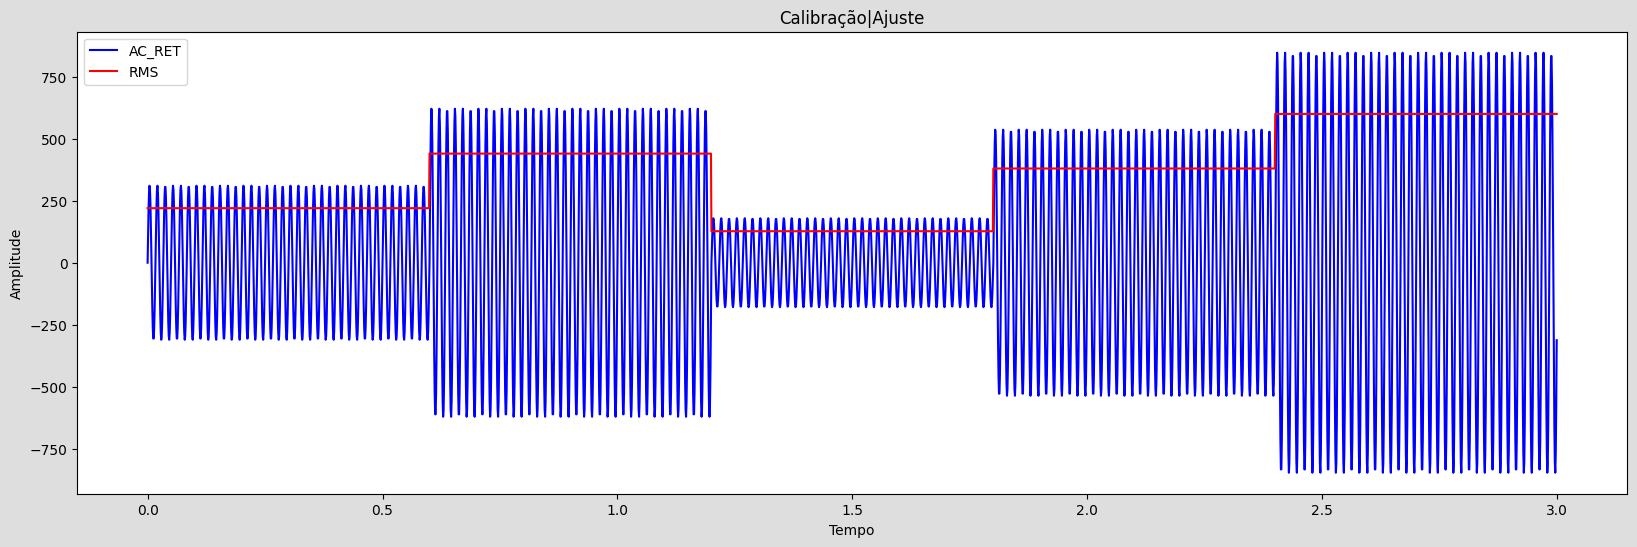

In [3]:
def adc_2_rms(vetor):
  rms = np.std(vetor, ddof=1)  # Calcula o valor RMS (Root Mean Square) usando o desvio padrão do vetor.
  return rms * np.ones(np.size(vetor))  # Retorna um vetor constante com o valor RMS repetido para o tamanho do vetor original.


def MMQ(y, mx):
  coef = (inv(mx.T @ mx)) @ (mx.T @ y)  # Resolve o sistema de equações usando o método dos mínimos quadrados.
  return coef  # Retorna os coeficientes da linearização.


# Dados do Sinal
# Define os parâmetros do sinal como frequência da rede elétrica, taxa de amostragem e duração da simulação.
GridFreq = 60  # Frequência nominal da rede elétrica em Hz.
Fs = 1000  # Frequência de amostragem de 1 kHz.
Tfinal = 3  # Tempo total de simulação (3 segundos).


# Variaveis calculadas
# Calcula o intervalo de amostragem, cria o vetor de tempo t e calcula a frequência angular w.
Ts = 1 / Fs  # Período de amostragem.
t = arange(0, Tfinal, Ts)  # Vetor de tempo para a simulação.
w = 2 * pi * GridFreq  # Frequência angular do sinal.

# constantes e projeto
# Define a quantidade de amostras usadas para cálculo do RMS e divide o vetor de tempo para diferentes condições.
step = 100  # Passo para calcular o RMS.
tamanho = floor(size(t) / 5)  # Divide o vetor de tempo em quatro regiões.


# Gera pontos como se estivesse lendo tensões alternadas.
supplyVoltage, rmsVoltage, y = np.array([]), np.array([]), np.array([])  # Inicializa vetores vazios para armazenar valores.
for n in range(0, size(t)):  # Itera sobre o vetor de tempo.
  match(n // tamanho):  # Define diferentes valores de tensão RMS baseados no índice `n`.
   case 0: rms = 220  # Região 1: Tensão RMS de 220V.
   case 1: rms = 440  # Região 2: Tensão RMS de 440V.
   case 2: rms = 127  # Região 3: Tensão RMS de 127V.
   case 3: rms = 380  # Região 4: Tensão RMS de 380V.
   case _: rms = 600  # Região 5: Tensão RMS de 600V.
  supplyVoltage = append(supplyVoltage, rms * sqrt(2) * sin(w * (n * Ts)))  # Adiciona valores de tensão alternada ao vetor `supplyVoltage`.
  y = append(y, rms)  # Adiciona os valores RMS ao vetor `y`.

  if(size(supplyVoltage) % step == 0 or size(supplyVoltage) == size(t)):  # A cada `step` ou ao final do vetor, calcula o RMS.
    rmsVoltage = append(rmsVoltage, adc_2_rms(supplyVoltage[-1 * step:]))  # Calcula o RMS das últimas `step` amostras.


# Ajuste Linear
y = np.asmatrix(y)  # Converte o vetor `y` em matriz para operações matriciais.
x = np.asmatrix(rmsVoltage)  # Converte o vetor `rmsVoltage` em matriz.

tam = np.size(x.T, 0)  # Obtém o número de amostras em `x`.
mx = np.concatenate((x.T, np.ones((tam, 1))), 1)  # Cria a matriz de design para o ajuste linear.
VCAL_M, VCAL_B = MMQ(y.T, mx)  # Calcula os coeficientes de ajuste linear (inclinação e intercepto).
V_RATIO = VCAL_M * rmsVoltage + VCAL_B  # Ajusta os valores calculados com os coeficientes obtidos.


# Gráficos
fig, ax = subplots(figsize=(20, 6), facecolor='#DEDEDE')  # Cria uma figura com tamanho e cor de fundo especificados.
title("Calibração|Ajuste")  # Adiciona um título ao gráfico.
line1, line2 = ax.plot(t, supplyVoltage, 'b', t, V_RATIO.T, 'r')  # Plota o sinal original e o sinal ajustado.
legend([line1, line2], ["AC_RET", "RMS"])  # Adiciona uma legenda ao gráfico.
xlabel('Tempo')  # Rotula o eixo X como 'Tempo'.
ylabel('Amplitude')  # Rotula o eixo Y como 'Amplitude'.


# Etapa 3: Insira mais uma faixa de 660 Volts na simulação